<a href="https://colab.research.google.com/github/dagbeme1/holbertonschool-gan/blob/master/Precision_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install wandb --upgrade


Mixed precision training is not supported on this device.


wandb: Currently logged in as: dennisagbedivi1. Use `wandb login --relogin` to force relogin


Epoch 1/5: 100%|██████████| 6/6 [13:22<00:00, 133.69s/it]


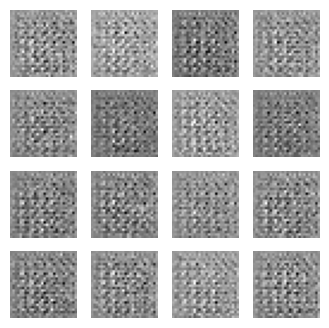

Epoch 2/5: 100%|██████████| 6/6 [14:21<00:00, 143.65s/it]


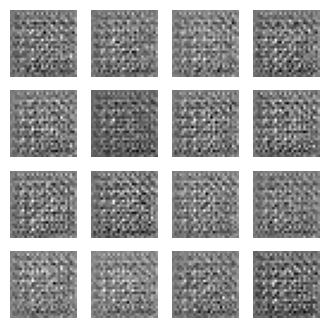

Epoch 3/5: 100%|██████████| 6/6 [13:43<00:00, 137.29s/it]


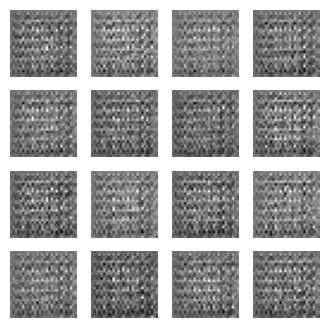

Epoch 4/5: 100%|██████████| 6/6 [13:42<00:00, 137.13s/it]


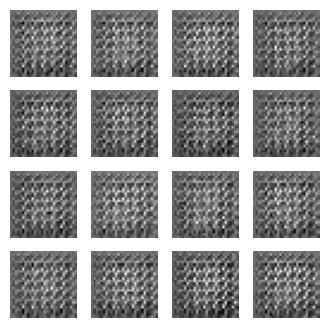

Epoch 5/5:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#!/usr/bin/env python3

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os
import time
from tqdm import tqdm  # Import tqdm for the progress bar

# Enable mixed-precision training (if supported)
if tf.config.experimental.list_physical_devices('GPU'):
    print("Mixed precision training supported.")
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy)
else:
    print("Mixed precision training is not supported on this device.")

# Define the generator model
def make_generator_model():
    """
    Creates and returns a generator model for DCGAN.

    Returns:
    tf.keras.Sequential: The generator model.
    """
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Define the discriminator model
def make_discriminator_model():
    """
    Creates and returns a discriminator model for DCGAN.

    Returns:
    tf.keras.Sequential: The discriminator model.
    """
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Define the loss functions for the generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """
    Calculates the discriminator's loss.

    Args:
    real_output (tf.Tensor): Output from the real data.
    fake_output (tf.Tensor): Output from the generated data.

    Returns:
    tf.Tensor: The total discriminator loss.
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """
    Calculates the generator's loss.

    Args:
    fake_output (tf.Tensor): Output from the generated data.

    Returns:
    tf.Tensor: The generator loss.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop
@tf.function
def train_step(images, generator):
    """
    Executes a single training step for the GAN.

    Args:
    images (tf.Tensor): Batch of real images.
    generator (tf.keras.Model): Generator model.

    Returns:
    None
    """
    noise = tf.random.normal([config.batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Define a function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    """
    Generates images using the generator model and saves them.

    Args:
    model (tf.keras.Model): Generator model.
    epoch (int): Current epoch.
    test_input (tf.Tensor): Input noise for generating images.

    Returns:
    None
    """
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Main training loop
def train(dataset, epochs, generator, discriminator):
    """
    Main training loop for the GAN.

    Args:
    dataset (tf.data.Dataset): Training dataset.
    epochs (int): Number of training epochs.
    generator (tf.keras.Model): Generator model.
    discriminator (tf.keras.Model): Discriminator model.

    Returns:
    None
    """
    for epoch in range(epochs):
        for image_batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}"):
            train_step(image_batch, generator)
        # Generate and save images after every epoch
        noise = tf.random.normal([16, 100])
        generate_and_save_images(generator, epoch + 1, noise)

# Initialize Weights and Biases for experiment tracking
wandb.init(project="dcgan_mnist")
config = wandb.config
config.epochs = 5
config.batch_size = 10000

# Load the MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 10000
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(config.batch_size)

# Create and compile the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Train the GAN
train(train_dataset, config.epochs, generator, discriminator)